# Health Insurance Analysis Across America
## PSTAT 134 Final Project


>Authors: Michael Hanson, Maya Samet, Alex Yam

In [4]:
import pandas as pd 
import numpy as np
! pip install plotly
import plotly
import seaborn as sns
import matplotlib as plt
from sklearn import preprocessing
import urllib, json
from pandas.io.json import json_normalize
import random
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.graphics.gofplots as sms

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The CDC has been conducting the National Health Interview Survey since 1957 and consists of over-the-phone interviews of willing participants across the country. This interview covers a wide list of questions concerning medical conditions, health insurance, doctor's office visits, physical activity, and health-care use. One of the main functions of the NHIS is to evaluate health programs as well as policies across the country. Along with this, the interview also serves to track health-related behaviors and health care use on a yearly basis. This is the CDC's main way of determining the general health of the nation.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Our goal in this project is to find relations in Health Insurance information and how it pertains to different regions demographics in the US. We want to be able to visualize any variation in the different aspects of health care recipient by comparing these different aspects to the cost of individuals' health insurance plan.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The first relation we can test is if there is any relation to the amount of total income a family brings in on an annual basis and the out-of-pocket premium cost of their health care. What we would expect to see is that people with a larger income will tend to pay more than those who have a lower income per year. However, before we can proceed, we have to remove certain outliers that my affect our final result. These particular outliers are included in every category of income per year and they consist of some premium cost numbers around $100,000, which our data set explains should be counted as N/A. After these observations are removed, we specify that we are only looking at the five specific income brackets and not the two other, more general brackets that are include in the data. We are working with 10,000 randomly sampled observations out of 80,000, using the "Person" and "Family" surveys combined. 

In [5]:
df = pd.read_csv("person_family_10k.csv")
df.head()

,Unnamed: 0,HHX,FMX,SRVY_YR,FPX,AGE_CHG,INTV_QRT,SEX,NOWAF,FSPOUS2,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,33245,3221,1,2017,1,NaN,1,1,2.0,NaN,...,4.0,1,1,2,1.0,2,2,1,NaN,1.0
1,15907,20785,1,2017,1,NaN,2,1,2.0,NaN,...,4.0,1,1,1,2.0,1,2,1,2.0,2.0
2,35584,33706,1,2017,1,NaN,3,1,2.0,NaN,...,NaN,0,2,2,NaN,2,1,1,2.0,0.0
3,34389,3295,1,2017,3,NaN,1,2,NaN,NaN,...,4.0,1,2,2,NaN,2,5,1,2.0,5.0
4,1504,11086,1,2017,3,NaN,1,2,NaN,NaN,...,NaN,1,1,1,1.0,2,2,1,NaN,NaN


As we can see, first column is just the observation number. We can delete it

In [6]:
df = df.drop(columns=["Unnamed: 0"], axis=1) 
df.head()

,HHX,FMX,SRVY_YR,FPX,AGE_CHG,INTV_QRT,SEX,NOWAF,FSPOUS2,COHAB1,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,3221,1,2017,1,NaN,1,1,2.0,NaN,NaN,...,4.0,1,1,2,1.0,2,2,1,NaN,1.0
1,20785,1,2017,1,NaN,2,1,2.0,NaN,2.0,...,4.0,1,1,1,2.0,1,2,1,2.0,2.0
2,33706,1,2017,1,NaN,3,1,2.0,NaN,NaN,...,NaN,0,2,2,NaN,2,1,1,2.0,0.0
3,3295,1,2017,3,NaN,1,2,NaN,NaN,NaN,...,4.0,1,2,2,NaN,2,5,1,2.0,5.0
4,11086,1,2017,3,NaN,1,2,NaN,NaN,NaN,...,NaN,1,1,1,1.0,2,2,1,NaN,NaN


Drop a few more unnecessary columns:

In [7]:
df = df.drop(columns=['SRVY_YR', 'PSTRAT', 'PPSU', 'AGE_CHG', 'RRP', 'HHREFLG',
                      'FMRPFLG', 'FMREFLG'])
df[df["HICOSTR1"]>20000]=np.NaN
df.head()

,HHX,FMX,FPX,INTV_QRT,SEX,NOWAF,FSPOUS2,COHAB1,COHAB2,FCOHAB3,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,3221.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,4.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,NaN,1.0
1,20785.0,1.0,1.0,2.0,1.0,2.0,NaN,2.0,NaN,2.0,...,4.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0
2,33706.0,1.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,0.0,2.0,2.0,NaN,2.0,1.0,1.0,2.0,0.0
3,3295.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,4.0,1.0,2.0,2.0,NaN,2.0,5.0,1.0,2.0,5.0
4,11086.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,2.0,2.0,1.0,NaN,NaN


# Exploratory Data Analysis

Here we will plot a boxplot of insurance premiums over income brackets:

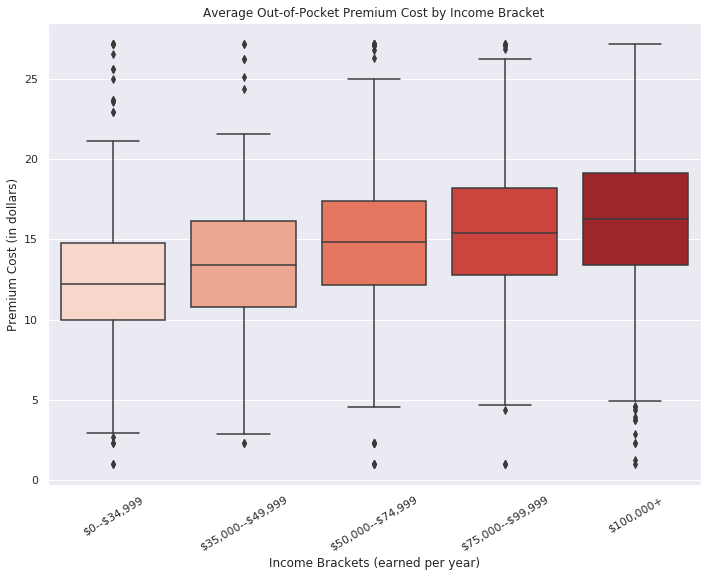

In [8]:
premium_cost = df[df.HICOSTR1 < 90000]['HICOSTR1'].dropna() #Removed outliers of 90K+ in every income bracket. 
income_bracket = df[df.INCGRP4 < 6]['INCGRP4'] #Removed non-specific income bracket.
sns.set(rc={'figure.figsize':(11.7, 8.5)})
sns.boxplot(income_bracket, np.power(premium_cost, 1/3), palette = 'Reds')
plt.pyplot.xlabel('Income Brackets (earned per year)')
plt.pyplot.ylabel('Premium Cost (in dollars)')
plt.pyplot.title('Average Out-of-Pocket Premium Cost by Income Bracket')
plt.pyplot.xticks([0,1,2,3,4],['\$0--\$34,999', '\$35,000--\$49,999', '\$50,000--\$74,999', '\$75,000--\$99,999', '$100,000+'], rotation = 30);

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What we see here is what we were expecting to see; higher averge out-of-pocket premium for people and families that make more money annually. Along with the boxes, we see that each bracket holds individuals that pay around $20,000 for their premiums and each backet holds about the same number of outliers above their respective boxes. Now, let's make a simplier line plot showing this increase in average premium cost per income bracket.

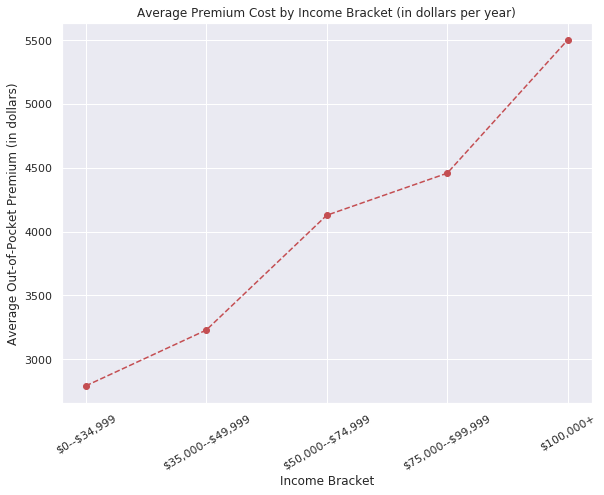

In [9]:
averages = premium_cost.groupby(income_bracket).mean()
sns.set(rc={'figure.figsize':(9.5, 7)})
plt.pyplot.plot(range(5), averages, 'o--r');
plt.pyplot.xlabel('Income Bracket')
plt.pyplot.ylabel('Average Out-of-Pocket Premium (in dollars)')
plt.pyplot.title('Average Premium Cost by Income Bracket (in dollars per year)')
plt.pyplot.xticks([0,1,2,3,4], ['\$0--\$34,999','\$35,000--\$49,999', '\$50,000--\$74,999', '\$75,000--\$99,999', '$100,000+'], rotation = 30);

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Some variables that could be significant and worth looking at are the age of the person and the race of the person. We can visualize this with with a scatter plot of the premium cost against the age of the individual. Along with this, we can distinguish between different races of the individuals by assigning a different color to each race. IN doing this we get:

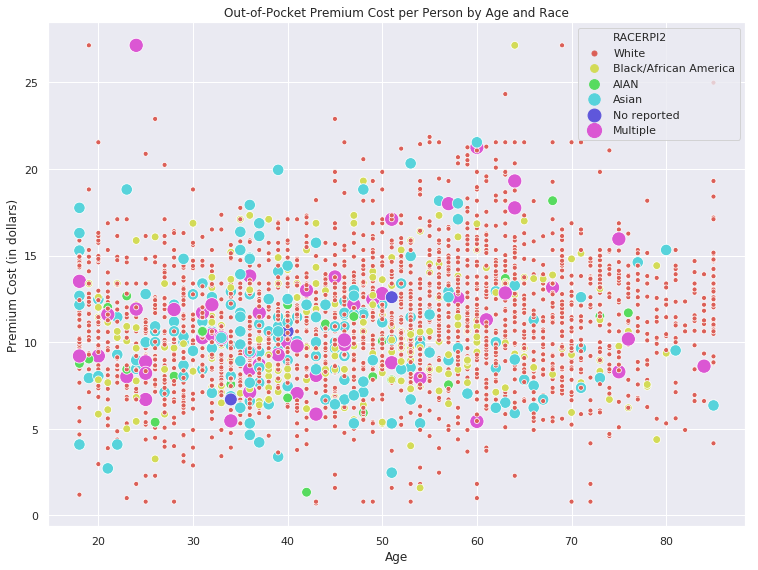

In [10]:
age = df[df.AGE_P>17] #Include only legal adults, as minors most likely aren't paying their own premium.
age['RACERPI2'] = pd.cut(age.RACERPI2, bins = [0,1,2,3,4,5,6], labels = ['White', 'Black/African America', 'AIAN', 'Asian', 'No reported', 'Multiple'])
cost_per_person = premium_cost/age['FM_SIZE'].dropna()
sns.set(rc={'figure.figsize':(12.5,9.27)})
g = sns.scatterplot(x=age['AGE_P'], y=np.power(cost_per_person, 1/3), hue = 'RACERPI2', data = age, palette = 'hls', size="RACERPI2", sizes=(200,25));
plt.pyplot.xlabel('Age')
plt.pyplot.ylabel('Premium Cost (in dollars)')
plt.pyplot.title("Out-of-Pocket Premium Cost per Person by Age and Race");

Initially the scatterplot showed no trend or relationship between the age of the individuals and their relative premium costs. And we could see no clear trend for the different races as well. Thus we decided to try to transform the data. In doing so, we have the plot above.
After transforming the cost per person the same way we transformed the data in the box plot earlier, we are still unable to see a clear trend between age and premium cost. Visualizing the different races in the plot, there does not seem to be a relationship where race affects premium cost. It also seems that many of the individuals that participated in the interview were between the ages of 30 and 50, which may explain the large grouping in that range of the plot.

# Alluvial Plot - Illnesses & Insurance Premium Brackets

Another topic we were interested in exploring is whether people suffering from disease or disability pay higher insurance premiums, and whether premium costs change in between individual diseases or disabilities. The survey has 34 different questions asking about different ailments. 

In [11]:
# create filter that will give us all disease flag variables
illness_filter = [col for col in df if col.startswith('LAHC')]

# create new df for this task, change responses to a simple y/n, sum to check how many people suffer from each disease
df_alluvial = df
df_alluvial[illness_filter] = df_alluvial[illness_filter].replace([2,3,4,5,6,7,8,9,np.NaN], 0)
df_alluvial[illness_filter].sum()
df_alluvial.head()

,HHX,FMX,FPX,INTV_QRT,SEX,NOWAF,FSPOUS2,COHAB1,COHAB2,FCOHAB3,...,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,3221.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,4.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,NaN,1.0
1,20785.0,1.0,1.0,2.0,1.0,2.0,NaN,2.0,NaN,2.0,...,4.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0
2,33706.0,1.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,0.0,2.0,2.0,NaN,2.0,1.0,1.0,2.0,0.0
3,3295.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,4.0,1.0,2.0,2.0,NaN,2.0,5.0,1.0,2.0,5.0
4,11086.0,1.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,2.0,2.0,1.0,NaN,NaN


What we're doing is changing any non-positive response to "do you suffer from this illness/disability" to a 0, since in the df as it is "no", "non-response", "not ascertained", "refused", etc. are all coded as different numbers, where for our purposes these can all effectively just be imputed with a "no". Summing the new columns gives us the amount of people in our dataset with each disease/disability. 

In [12]:
alluvial_bool = df_alluvial[illness_filter].sum()>0
new_illness_filter = alluvial_bool[alluvial_bool==1].index.values
df_alluvial = df_alluvial.drop(alluvial_bool[alluvial_bool==0].index.values, axis=1)
df_alluvial[new_illness_filter].sum().head()

LAHCC1     4.0
LAHCC2     6.0
LAHCC3    43.0
LAHCC4     8.0
LAHCC5    14.0
dtype: float64

As we can see, quite a few diseases/disabilities have quite a low n-count. Later, we will be aggregating all of these questions into 4 groups: physical disability, physical illness, mental disability, mental illness. Now: create bucketed variable of annual insurance premium expenses

In [13]:
conditions = [
    (df_alluvial['HICOSTR1'] < 2500), (df_alluvial['HICOSTR1'] < 5000),
    (df_alluvial['HICOSTR1'] < 7500), (df_alluvial['HICOSTR1'] < 10000),
    (df_alluvial['HICOSTR1'] < 12500), (df_alluvial['HICOSTR1'] < 15000),
    (df_alluvial['HICOSTR1'] < 17500), (df_alluvial['HICOSTR1'] < 20000),
    (df_alluvial['HICOSTR1'] > 99996)]

choices = ['Less than $2500', '$2,500-$4,999', 
           '$5,000-$7,499', '$7,500-$9,999',
           '$10,000-$12,499', '$12,500-$14,999',
           '$15,000-$17,499', '$17,500-$19,999',
           np.nan]

df_alluvial['PRM_BCKT'] = np.select(conditions, choices, default='Over $20,000')
df_alluvial['PRM_BCKT'].head()

0       Over $20,000
1    Less than $2500
2      $7,500-$9,999
3       Over $20,000
4       Over $20,000
Name: PRM_BCKT, dtype: object

Next, let's trim our dataset down and continue to manipulate it into the correct shape for an alluvial plot.

In [14]:
df_alluvial = pd.concat([df_alluvial[new_illness_filter], df_alluvial['PRM_BCKT']], axis=1)
df_alluvial = df_alluvial.groupby('PRM_BCKT').sum()
df_alluvial['order'] = [5,6,7,8,2,3,4,1,9]
df_alluvial = df_alluvial.sort_values(by=['order']).drop(columns=['order'])
df_alluvial.head()

,LAHCC1,LAHCC2,LAHCC3,LAHCC4,LAHCC5,LAHCC6,LAHCC8,LAHCC9,LAHCC10,LAHCC11,...,LAHCA26_,LAHCA27_,LAHCA28_,LAHCA30_,LAHCA31_,LAHCA32_,LAHCA33_,LAHCA34_,LAHCA14A,LAHCC7A
PRM_BCKT,,,,,,,,,,,,,,,,,,,,,
Less than $2500,0.0,2.0,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,2.0,0.0,3.0,0.0
"$2,500-$4,999",0.0,0.0,5.0,1.0,2.0,2.0,3.0,3.0,2.0,0.0,...,1.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0
"$5,000-$7,499",1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0
"$7,500-$9,999",0.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"$10,000-$12,499",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Alright. Now we will group and sum the columns into larger categories according to the type of illness or disability that they cover:

In [15]:
df_alluvial["Physical Disability"] = df_alluvial[["LAHCC1","LAHCC2","LAHCC3","LAHCC4","LAHCC5",
                                                 "LAHCC6","LAHCC10","LAHCC11","LAHCA1","LAHCA2",
                                                 "LAHCA3","LAHCA4","LAHCA5","LAHCA6","LAHCA13",
                                                 "LAHCA18","LAHCA19_","LAHCA20_","LAHCA31_",
                                                 "LAHCA34_"]].sum(axis=1)

df_alluvial["Mental Disability"] = df_alluvial[["LAHCC7A","LAHCC8","LAHCC9","LAHCC12","LAHCC13",
                                               "LAHCA14A","LAHCA15","LAHCA16","LAHCA32_","LAHCA33_"]].sum(axis=1)

df_alluvial["Physical Illness"] = df_alluvial[["LAHCA7","LAHCA8","LAHCA9","LAHCA10","LAHCA11",
                                               "LAHCA12",'LAHCA22_','LAHCA23_','LAHCA24_','LAHCA25_',
                                               'LAHCA26_', 'LAHCA27_', 'LAHCA28_']].sum(axis=1)

df_alluvial['Mental Illness'] = df_alluvial[["LAHCA17","LAHCA30_"]].sum(axis=1)

df_alluvial = df_alluvial[['Physical Disability', 'Mental Disability', 'Physical Illness', 'Mental Illness']]
df_alluvial

,Physical Disability,Mental Disability,Physical Illness,Mental Illness
PRM_BCKT,,,,
Less than $2500,148.0,33.0,65.0,10.0
"$2,500-$4,999",105.0,15.0,71.0,12.0
"$5,000-$7,499",39.0,20.0,23.0,1.0
"$7,500-$9,999",18.0,7.0,2.0,2.0
"$10,000-$12,499",2.0,3.0,6.0,1.0
"$12,500-$14,999",0.0,1.0,0.0,0.0
"$15,000-$17,499",3.0,7.0,0.0,0.0
"$17,500-$19,999",0.0,0.0,0.0,0.0
"Over $20,000",941.0,221.0,687.0,204.0


The value of each cell should be an observation in a new df, with the column index being the source and the row index (+4) being the target. Let's implement this. 

In [16]:
df_allu = pd.DataFrame(columns=['Source','Target','Value'])

for i in range(4):
    for j in range(8):
        Source = i
        Target = j+4
        Value = df_alluvial.iloc[j,i]
        templist = [Source, Target, Value]
        Dict = dict(zip(df_allu.columns, templist))
        df_allu=df_allu.append(Dict, ignore_index=True)

df_allu.head()

,Source,Target,Value
0,0.0,4.0,148.0
1,0.0,5.0,105.0
2,0.0,6.0,39.0
3,0.0,7.0,18.0
4,0.0,8.0,2.0


Now we add columns for the label and the color! We also only want to keep observations where value>0, meaning at least one person has the corresponding source and target.

In [17]:
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))

LabCol = pd.DataFrame({
    "Label":df_alluvial.columns.tolist() + df_alluvial.index.tolist(),
    "Color":get_colors(13)})

df_allu = pd.concat([LabCol, df_allu], axis=1)

df_allu = df_allu[df_allu['Value']>0]

df_allu

,Label,Color,Source,Target,Value
0,Physical Disability,#67d7af,0.0,4.0,148.0
1,Mental Disability,#8344f2,0.0,5.0,105.0
2,Physical Illness,#2a5295,0.0,6.0,39.0
3,Mental Illness,#37c417,0.0,7.0,18.0
4,Less than $2500,#ff6023,0.0,8.0,2.0
6,"$5,000-$7,499",#71d831,0.0,10.0,3.0
8,"$10,000-$12,499",#24a58e,1.0,4.0,33.0
9,"$12,500-$14,999",#ea9e65,1.0,5.0,15.0
10,"$15,000-$17,499",#0149d4,1.0,6.0,20.0
11,"$17,500-$19,999",#3c8eb8,1.0,7.0,7.0


And that's our data! For our alluvial plot we want to see how sufferers of different types of illness and disability are spread between these insurance expense brackets. Now that we have our data prepared, let's plot. Just for fun we have made this plot using a random color generator, so the variables will be in different colors every time they are plotted. Not especially practical, but a fun experiment!

In [20]:
plotly.tools.set_credentials_file(username='msamet', api_key='v4KEDBPNKh2TnLbLbk0Q')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [21]:
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  df_allu['Label'].dropna(axis=0, how='any'),
      color = df_allu['Color']
    ),
    link = dict(
      source = df_allu['Source'].dropna(axis=0, how='any'),
      target = df_allu['Target'].dropna(axis=0, how='any'),
      value = df_allu['Value'].dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Insurance Bracket Distribution Among the Ill and Disabled",
    height = 772,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
plotly.plotly.iplot(fig, validate=False)

An interesting pattern emerges: the physically disabled seem to pay lower insurance premiums than their otherwise-ailed brethren. It would be interesting to investigate the reasons behind this. My guess - physical disabilities are more easily covered by Medicare, leading to many of the physically disabled paying $0 insurance premiums. In order to be elligible for Medicare you must have been recieving SSDI (Social Security Disability Income) for over a year, and going by this government [website](https://www.ssa.gov/planners/disability/qualify.html), it does seem like government disability status is more easily reached by physical disabilities than other ailments. 

# Regional Premium Costs

Another question we were interested in is whether region played into insurance premium. The data in our dataset is separated into four regions: *Northeast, Midwest, South, and West*. Unfortunately information is unavailable on the individual state level. Here is a visualization of the spread:

In [22]:
conditions = [
    (df['REGION'] == 1), (df['REGION'] == 2),
    (df['REGION'] == 3), (df['REGION'] == 4)]

choices = ['Northeast', 'Midwest', 'South', 'West']

df['REG_STR'] = np.select(conditions, choices, default=np.NaN)

###

df_States = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')[['code','state']]

conditions = [
    (df_States['state'].isin(["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", 
                              "Connecticut", "New York", "New Jersey", "Pennsylvania"])),
    (df_States['state'].isin(["Ohio", "Michigan", "Indiana", "Wisconsin", "Illinois", "Minnesota", 
                              "Iowa", "Missouri", "North Dakota", "South Dakota", "Nebraska", "Kansas"])),
    (df_States['state'].isin(["Delaware", "Maryland", "Virginia", "West Virginia", "Kentucky", "North Carolina", 
                              "South Carolina", "Tennessee", "Georgia", "Florida", "Alabama", "Mississippi", 
                              "Arkansas", "Louisiana", "Texas", "Oklahoma"])),
    (df_States['state'].isin(["Montana", "Idaho", "Wyoming", "Colorado", "New Mexico", "Arizona", "Utah", 
                              "Nevada", "California", "Oregon", "Washington", "Alaska", "Hawaii"]))
]

choices = ['Northeast', 'Midwest', 'South', 'West']

df_States['REG_STR'] = np.select(conditions, choices)

###

conditions = [
    (df_States['REG_STR']=='Northeast'),
    (df_States['REG_STR']=='Midwest'),
    (df_States['REG_STR']=='South'),
    (df_States['REG_STR']=='West')
]

choices = [0, 0.33, 0.67, 1]

df_States['REG_NUM'] = np.select(conditions, choices, default=np.NaN)

###

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

scl = [
    [0, 'red'],
    [0.33, 'blue'],
    [0.67, 'green'],
    [1, 'yellow']
]

df_States['text'] = df_States['state'] + '<br>' +  'Region ' + df_States['REG_STR']

data = [go.Choropleth(
    colorscale = scl,
    autocolorscale = False,
    locations = df_States['code'],
    z = df_States['REG_NUM'],
    locationmode = 'USA-states',
    text = df_States['text'],
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(255,255,255)',
            width = 1
        )),
    showscale=False,
    #colorbar = go.choropleth.ColorBar(
    #    title = "Region",
        )
]

layout = go.Layout(
    title = go.layout.Title(
        text = 'West, South, Midwest, Northeast Defined as Follows:'
    ),
    geo = go.layout.Geo(
        scope = 'usa',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = False)
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'd3-cloropleth-map')

Now we plotted the average insurance premium by income and region:

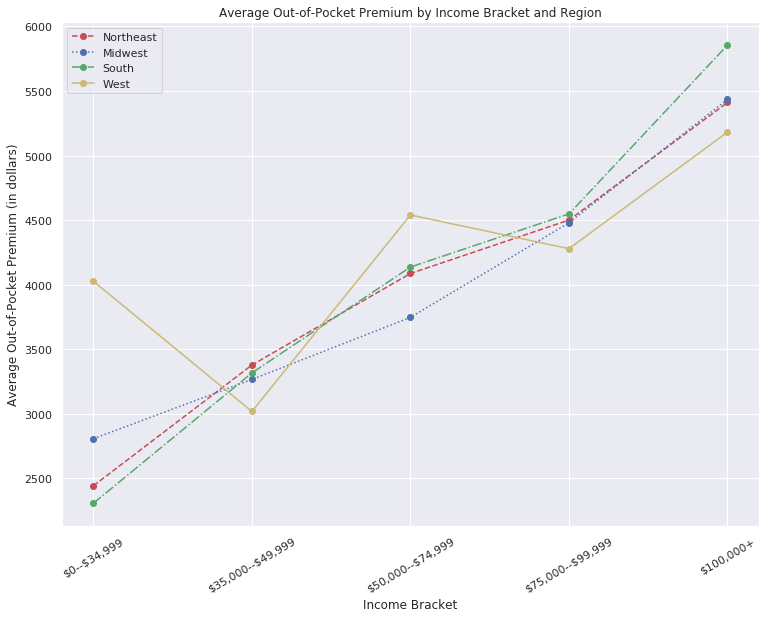

In [23]:
df_reg=df

income_bracket = df_reg[df_reg.INCGRP4 < 6]['INCGRP4']

df_reg_cost = df_reg[df_reg.HICOSTR1 < 90000]
premium_cost_r1 = df_reg_cost[df_reg.REGION == 1]['HICOSTR1'].dropna()
premium_cost_r2 = df_reg_cost[df_reg.REGION == 2]['HICOSTR1'].dropna()
premium_cost_r3 = df_reg_cost[df_reg.REGION == 3]['HICOSTR1'].dropna()
premium_cost_r4 = df_reg_cost[df_reg.REGION == 4]['HICOSTR1'].dropna()
ave_r1 = premium_cost_r1.groupby(income_bracket).mean()
ave_r2 = premium_cost_r2.groupby(income_bracket).mean()
ave_r3 = premium_cost_r3.groupby(income_bracket).mean()
ave_r4 = premium_cost_r4.groupby(income_bracket).mean()
plt.pyplot.plot(ave_r1, 'o--r', label = 'Northeast')
plt.pyplot.plot(ave_r2, 'o:b', label = 'Midwest')
plt.pyplot.plot(ave_r3, 'o-.g', label = 'South')
plt.pyplot.plot(ave_r4, 'o-y', label = 'West')
plt.pyplot.xlabel('Income Bracket')
plt.pyplot.ylabel('Average Out-of-Pocket Premium (in dollars)')
plt.pyplot.title('Average Out-of-Pocket Premium by Income Bracket and Region')
plt.pyplot.legend()
plt.pyplot.xticks([1,2,3,4,5], ['\$0--\$34,999','\$35,000--\$49,999', '\$50,000--\$74,999', '\$75,000--\$99,999', '$100,000+'], rotation = 30);

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What we see here the Northeast, Midwest, and Southern regions all follow a similar trend to what we see in the previous graph of national average. However, we also see a completely different trend from the Western region, which was not an expected result at all. We can see that people in the lowest income bracket of the Western region are paying more than a thousand dollars on average than any other region all while the people in the highest income bracket are paying less than any other region. This interesting result leads us to see if there are any more variables that can be considered significant in predicting the premium cost.

In our next notebook, we will be creating and interpreting some models and offering a conclusion to our project! 